In [ ]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training
from manifold_flow import nn as nn_
from experiments.data_generation.spherical_simulator import simulator, true_logp

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Data

In [6]:
latent_dim = 1
data_dim = 2
n = 10000
epsilon = 0.02

phases = np.random.uniform(low=0., high=2.*np.pi, size=latent_dim)
widths = np.random.uniform(low=0.5, high=2., size=latent_dim)

x = simulator(epsilon, latent_dim, data_dim, n, phases, widths)

phases, widths

(array([2.65169924]), array([1.77960825]))

../../experiments/data_generation/spherical_simulator.py:58: RuntimeWarning: invalid value encountered in true_divide
  x[:, i] / np.sum(x[:, i : latent_dim + 1] ** 2, axis=1) ** 0.5
../../experiments/data_generation/spherical_simulator.py:58: RuntimeWarning: invalid value encountered in arccos
  x[:, i] / np.sum(x[:, i : latent_dim + 1] ** 2, axis=1) ** 0.5
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
../../experiments/data_generation/spherical_simulator.py:74: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=epsilon).pdf(z_eps))
../../experiments/data_generation/spherical_simulator.py

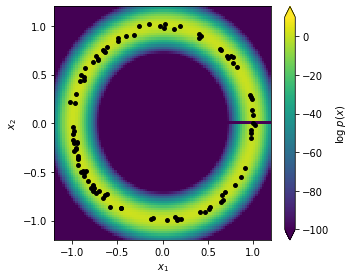

In [7]:
res = 101
x_range = np.linspace(-1.2,1.2,res)
y_range = np.linspace(-1.2,1.2,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = true_logp(x_grid, epsilon, latent_dim, phases, widths).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = -100., 10.
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(logp_grid, zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x[::100,0], x[::100,1], s=15., c="black")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf")

## Train manifold flow

In [8]:
trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=20,
    num_transform_blocks=3,
    dropout_probability=0.,
    use_batch_norm=False
)

flow = flows.autoencoding_flow.TwoStepAutoencodingFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=None,
    outer_transform=trf,
)

11:32 manifold_flow.flows.autoencodi DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
11:32 manifold_flow.flows.autoencodi DEBUG   Created autoencoding flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 GB


In [10]:
x_tensor = torch.from_numpy(x)
dataset = TensorDataset(x_tensor, x_tensor)

trainer = training.trainer.AutoencodingFlowTrainer(flow)
trainer.train(
    dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[1., 0.],
    epochs=10,
)

11:33 manifold_flow.training.trainer INFO    Training on CPU with single precision
11:33 manifold_flow.training.trainer DEBUG   Initialising training data
11:33 manifold_flow.training.trainer DEBUG   Setting up optimizer
11:33 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
11:33 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
11:33 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
11:33 manifold_flow.training.trainer DEBUG   Beginning main training loop
11:33 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
11:33 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
11:34 manifold_flow.training.trainer INFO    Epoch   1: train loss  0.23731 (mse:  0.237, nll: -4.664)
11:34 manifold_flow.training.trainer INFO               val. loss   0.19982 (mse:  0.200, nll: -3.258)
11:34 manifold_flow.training.trainer DEBUG   Training epoch 2 / 10
11:34 manifold_flow.training.trainer DEBUG     L

(array([0.23731122, 0.14499042, 0.07043879, 0.02043192, 0.01209228,
        0.01193438, 0.01080526, 0.01040174, 0.00913186, 0.00770904]),
 array([0.19981875, 0.10727807, 0.05026665, 0.01351961, 0.01044803,
        0.01330385, 0.0118127 , 0.00854293, 0.00888041, 0.01058546]))

In [45]:
trainer.train(
    dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[1., 0.01],
    epochs=10,
)

11:59 manifold_flow.training.trainer DEBUG   Initialising training data
11:59 manifold_flow.training.trainer DEBUG   Setting up optimizer
11:59 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
11:59 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
11:59 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
11:59 manifold_flow.training.trainer DEBUG   Beginning main training loop
11:59 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
11:59 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
12:00 manifold_flow.training.trainer INFO    Epoch   1: train loss -0.00443 (mse:  0.026, nll: -3.054)
12:00 manifold_flow.training.trainer INFO               val. loss  -0.01205 (mse:  0.017, nll: -2.928)
12:00 manifold_flow.training.trainer DEBUG   Training epoch 2 / 10
12:00 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
12:01 manifold_flow.training.trainer INFO    Epoch   2: train

(array([-0.00442594,  0.00021242, -0.0139992 , -0.00057945,  0.03246357,
        -0.0157541 , -0.00865989, -0.00961033, -0.01505697, -0.01809554]),
 array([-0.01204924, -0.01027252, -0.02034538, -0.01300434, -0.013886  ,
        -0.01930475, -0.01830375, -0.01400179, -0.0189436 , -0.02129557]))

## Manifold flow performance

### Generation

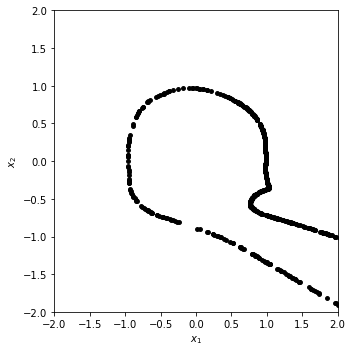

In [46]:
x_gen = flow.sample(n=1000)

# res = 101
# x_range = np.linspace(-1.2,1.2,res)
# y_range = np.linspace(-1.2,1.2,res)
# xx, yy = np.meshgrid(x_range, y_range)
# x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
# logp_grid = true_logp(x_grid, epsilon, latent_dim, phases, widths).reshape((res, res))
# logp_grid[~np.isfinite(logp_grid)] = -1000000.

# zmin, zmax = -100., 10.
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

# pcm = plt.pcolormesh(
#     x_range, y_range,
#     np.clip(logp_grid, zmin, zmax),
#     cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
# )
# cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=15., c="black")

plt.xlim(-2.0,2.0)
plt.ylim(-2.0,2.0)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_generation.pdf")

### Reconstruction

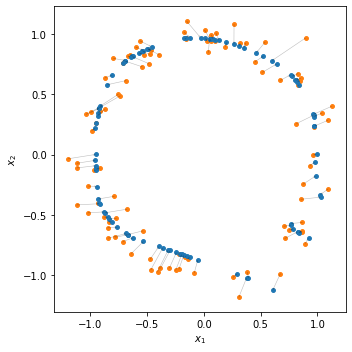

In [47]:
x_in = simulator(5*epsilon, latent_dim, data_dim, 100, phases, widths)
x_in = torch.FloatTensor(x_in)
x_out = flow(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=0.25
)

# plt.xlim(-1.2,1.2)
# plt.ylim(-1.2,1.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_reconstruction.pdf")


### Log likelihood

In [51]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)
logp_grid = flow.log_prob(x_grid_tensor)


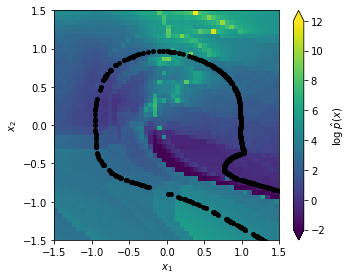

In [52]:
zmin, zmax = -2., 12.
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(logp_grid.detach().numpy().reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
#plt.scatter(x[::100,0], x[::100,1], s=15., c="black")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=15., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_log_prob.pdf")

## Latent variables

In [61]:
res = 51
x_range = np.linspace(-100.,100.,res)
y_range = np.linspace(-100.,100.,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

_, _, u = flow(x_grid_tensor)


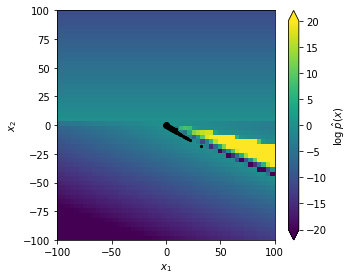

In [64]:
zmin, zmax = -20., 20.
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(u.detach().numpy().reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
#plt.scatter(x[::100,0], x[::100,1], s=15., c="black")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=5., c="black")

plt.xlim(-100.,100.)
plt.ylim(-100.,100.)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_latent.pdf")